In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import numpy as np
import sklearn as sk

pd.options.display.max_columns = None
# Data Initialization
flood_df = pd.read_csv('data/flooding_events_augmented.csv', dtype=str, keep_default_na=False)
non_flood_df = pd.read_csv('data/non_flooding_events_normal_augmented.csv', dtype=str, keep_default_na=False)
county_test_df = pd.read_csv('data/testing_county_data.csv', dtype=str, keep_default_na=False)

In [2]:
# Robust missing detector (so blanks like "", "NA", "null" count as missing)
MISSING_TOKENS = {"", " ", "na", "n/a", "null", "none", "nan"}
def is_na_like(s):
    s = str(s).strip().lower()
    return s in MISSING_TOKENS

In [3]:
KNOWN_NUMERIC = [
    "YEAR", "MONTH", "BEGIN_DAY", "BEGIN_TIME", "BEGIN_LAT", "BEGIN_LON", "temperature_2m_mean", 
    "wind_speed_10m_mean", "cloud_cover_mean", "relative_humidity_2m_mean", "dew_point_2m_mean", 
    "precipitation_sum", "rain_sum", "snowfall_sum", "pressure_msl_mean", "soil_moisture_0_to_10cm_mean", 
    "elevation"
]
def coerce_numeric(df):
    # Try to coerce known numeric columns; leave others as text
    present_numeric = [c for c in KNOWN_NUMERIC if c in df.columns]
    for c in present_numeric:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [4]:
coerce_numeric(flood_df)
coerce_numeric(non_flood_df)
coerce_numeric(county_test_df)

In [5]:
def output_missing(df, name):
    miss_rows = []
    for c in df.columns:
        if c in [col for col in KNOWN_NUMERIC if col in df.columns]:
            miss = df[c].isna().sum()
        else:
            miss = df[c].apply(is_na_like).sum()
        miss_rows.append({"column": c, "missing": int(miss), "missing_%": round(miss*100/len(flood_df), 2)})
    miss_df = pd.DataFrame(miss_rows).sort_values("missing", ascending=False)
    print(f"\n=== MISSING VALUES (robust) for the {name} dataset ===")
    print(miss_df.to_string(index=False))

In [6]:
output_missing(flood_df, 'flood_df')
output_missing(non_flood_df, 'non_flood_df')
output_missing(county_test_df, 'county_test_df')


=== MISSING VALUES (robust) for the flood_df dataset ===
                      column  missing  missing_%
                snowfall_sum      997      10.67
                    rain_sum      997      10.67
                 FLOOD_CAUSE      526       5.63
             EVENT_NARRATIVE       93       1.00
soil_moisture_0_to_10cm_mean       32       0.34
                        YEAR        0       0.00
            cloud_cover_mean        0       0.00
           pressure_msl_mean        0       0.00
           precipitation_sum        0       0.00
           dew_point_2m_mean        0       0.00
   relative_humidity_2m_mean        0       0.00
         temperature_2m_mean        0       0.00
         wind_speed_10m_mean        0       0.00
                       MONTH        0       0.00
                  EVENT_TYPE        0       0.00
                       STATE        0       0.00
                   BEGIN_LON        0       0.00
                   BEGIN_LAT        0       0.00
           

In [7]:
def explore_data_shape(df, name):
    print(f"=== {name} DATA SHAPE & COLUMNS ===")
    print(f"Rows: {len(df):,}  |  Columns: {len(df.columns)}")
    print("Columns:", ", ".join(df.columns))
    print("\n=== HEAD(10) ===")
    print(df.head(10).to_string(index=False))
    print("\n=== TAIL(5) ===")
    print(df.tail(5).to_string(index=False))
    print('\n')

In [9]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

explore_data_shape(flood_df, 'flood_df')
explore_data_shape(non_flood_df, 'non_flood_df')
explore_data_shape(county_test_df, 'county_test_df')

=== flood_df DATA SHAPE & COLUMNS ===
Rows: 9,340  |  Columns: 21
Columns: YEAR, MONTH, BEGIN_DAY, BEGIN_TIME, BEGIN_LAT, BEGIN_LON, STATE, EVENT_TYPE, FLOOD_CAUSE, EVENT_NARRATIVE, temperature_2m_mean, wind_speed_10m_mean, cloud_cover_mean, relative_humidity_2m_mean, dew_point_2m_mean, precipitation_sum, rain_sum, snowfall_sum, pressure_msl_mean, soil_moisture_0_to_10cm_mean, elevation

=== HEAD(10) ===
 YEAR  MONTH  BEGIN_DAY  BEGIN_TIME  BEGIN_LAT  BEGIN_LON STATE  EVENT_TYPE FLOOD_CAUSE                                                                           EVENT_NARRATIVE  temperature_2m_mean  wind_speed_10m_mean  cloud_cover_mean  relative_humidity_2m_mean  dew_point_2m_mean  precipitation_sum  rain_sum  snowfall_sum  pressure_msl_mean  soil_moisture_0_to_10cm_mean  elevation
 2001      3         11         140   32.53333  -96.66667 TEXAS Flash Flood                                                      Roads were closed near Sanger due to high water.            18.331040       

In [10]:
def describe_numeric(df, name):
    if [c for c in KNOWN_NUMERIC if c in df.columns]:
        desc = df[[c for c in KNOWN_NUMERIC if c in df.columns]].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
        desc = desc.rename(columns={"50%":"median"}).reset_index().rename(columns={"index":"column"})
        print(f"\n=== NUMERIC STATS (describe) for {name} ===")
        print(desc.round(3).to_string(index=False))
    else:
        print(f"\n(No numeric columns in {name} found to describe.)")

In [11]:
describe_numeric(flood_df, 'flood_df')
describe_numeric(non_flood_df, 'non_flood_df')
describe_numeric(county_test_df, 'county_test_df')


=== NUMERIC STATS (describe) for flood_df ===
                      column  count     mean     std      min       1%       5%      25%   median      75%      95%      99%      max
                        YEAR 9340.0 2014.298   5.945 2001.000 2004.000 2005.000 2009.000 2015.000 2019.000 2024.000 2025.000 2025.000
                       MONTH 9340.0    6.375   2.458    1.000    1.000    3.000    5.000    6.000    8.000   10.000   12.000   12.000
                   BEGIN_DAY 9340.0   16.600   8.940    1.000    1.000    2.000    9.000   17.000   25.000   30.000   31.000   31.000
                  BEGIN_TIME 9340.0 1227.021 664.690    0.000    0.000  115.000  700.000 1252.500 1813.000 2220.000 2331.000 2359.000
                   BEGIN_LAT 9340.0   31.183   2.019   25.818   26.161   27.670   29.780   31.407   32.702   34.065   35.428   36.464
                   BEGIN_LON 9340.0  -98.083   2.497 -106.636 -105.876 -102.379  -99.550  -97.732  -96.426  -94.410  -93.950  -93.219
         temper

In [13]:
def explore_categorical(df, name):
    cat_cols = ["EVENT_TYPE"]
    
    if cat_cols:
        print(f"\n=== CATEGORICAL STATS (describe for object) in {name} ===")
        print(df[cat_cols].describe(include=['object']).to_string())
        print(f"\n=== CATEGORICAL VALUE COUNTS (top 20 each) in {name} ===")
        for col in cat_cols:
            s = df[col].astype(str)
            s = s.where(~s.apply(is_na_like), "<MISSING>")
            vc = s.value_counts(dropna=False)
            top = vc.head(20)
            print("-"*100)
            print(f"{col} | distinct={vc.shape[0]} | top 20 shown")
            print(pd.DataFrame({"value": top.index, "count": top.values, "percent": (top.values/len(s)*100).round(2)}).to_string(index=False))
            ax = top.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(top)), title=col)
            ax.set_xlabel("Count")
            plt.tight_layout()
            plt.show()
    else:
        print(f"\n(No categorical columns in {name} detected under current rules.)")


=== CATEGORICAL STATS (describe for object) in flood_df ===
         EVENT_TYPE
count          9340
unique            2
top     Flash Flood
freq           8022

=== CATEGORICAL VALUE COUNTS (top 20 each) in flood_df ===
----------------------------------------------------------------------------------------------------
EVENT_TYPE | distinct=2 | top 20 shown
      value  count  percent
Flash Flood   8022    85.89
      Flood   1318    14.11


/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_48166/3167055182.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


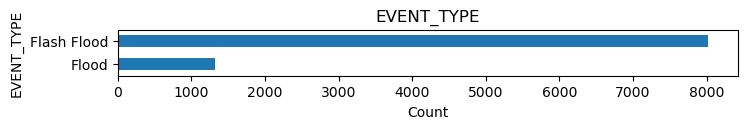


=== CATEGORICAL STATS (describe for object) in non_flood_df ===
       EVENT_TYPE
count        9340
unique          1
top        Normal
freq         9340

=== CATEGORICAL VALUE COUNTS (top 20 each) in non_flood_df ===
----------------------------------------------------------------------------------------------------
EVENT_TYPE | distinct=1 | top 20 shown
 value  count  percent
Normal   9340    100.0


/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_48166/3167055182.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


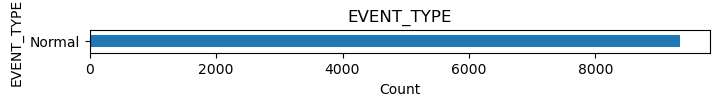

In [15]:
explore_categorical(flood_df, 'flood_df')
explore_categorical(non_flood_df, 'non_flood_df')

In [98]:
def explore_numeric(col, df, name, bins=50):
    print(f" --- {name} ---\n")
    if col not in df.columns:
        print(f"{col} not found"); return
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"{col}: no numeric data"); return
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(col)
    axes[0].hist(s, bins=bins); axes[0].set_title("Histogram"); axes[0].grid(True, alpha=0.3)
    axes[1].boxplot(s, vert=True, showfliers=True); axes[1].set_title("Boxplot"); axes[1].grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).round(3))

def visualize_categorical(col, df, name, top_n=30):
    print(f" --- {name} ---\n")
    if col not in df.columns:
        print(f"{col} not found"); return
    s_raw = df[col].astype(str)
    s = s_raw.where(~s_raw.apply(is_na_like), "<MISSING>")
    vc = s.value_counts()
    print(f"{col} | distinct={vc.shape[0]} | total={len(s)} | missing={(s=='<MISSING>').sum()}")
    show = vc.head(top_n)
    print(pd.DataFrame({
        "value": show.index,
        "count": show.values,
        "percent": (show.values/len(s)*100).round(2)
    }).to_string(index=False))
    ax = show.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(show)), title=col)
    ax.set_xlabel("Count")
    plt.tight_layout()
    plt.show()

 --- flood_df ---



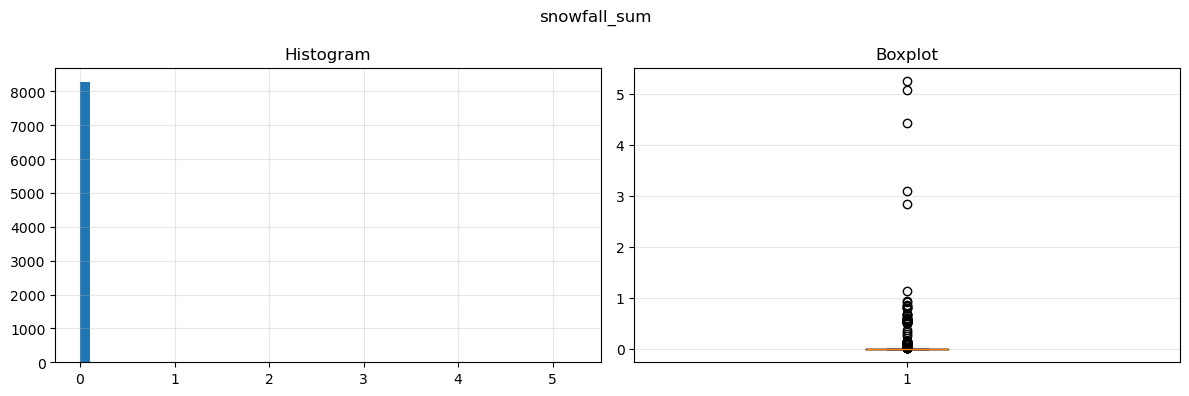

count    8343.000
mean        0.006
std         0.114
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         0.000
95%         0.000
99%         0.000
max         5.247
Name: snowfall_sum, dtype: float64


In [99]:
explore_numeric("snowfall_sum", flood_df, 'flood_df')

 --- flood_df ---



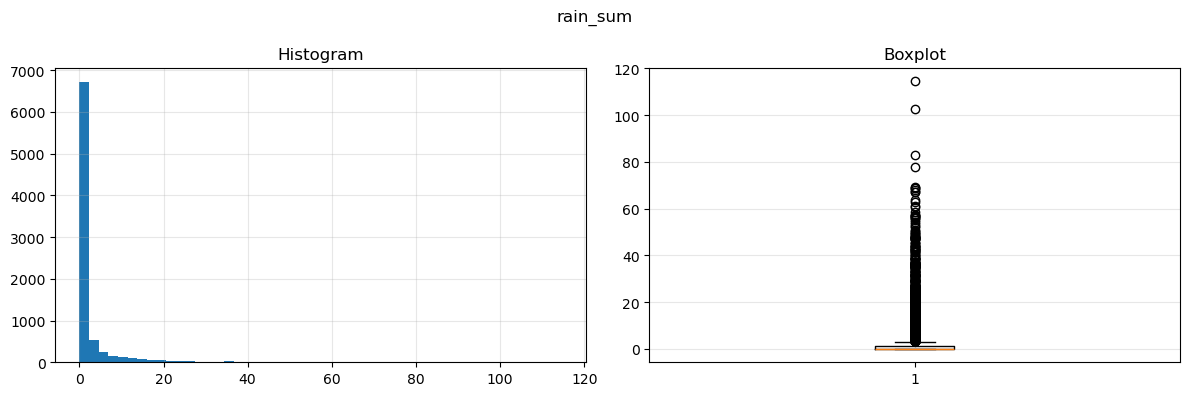

count    8343.000
mean        2.501
std         7.082
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         1.261
95%        14.487
99%        36.113
max       114.628
Name: rain_sum, dtype: float64


In [100]:
explore_numeric("rain_sum", flood_df, 'flood_df')

 --- flood_df ---



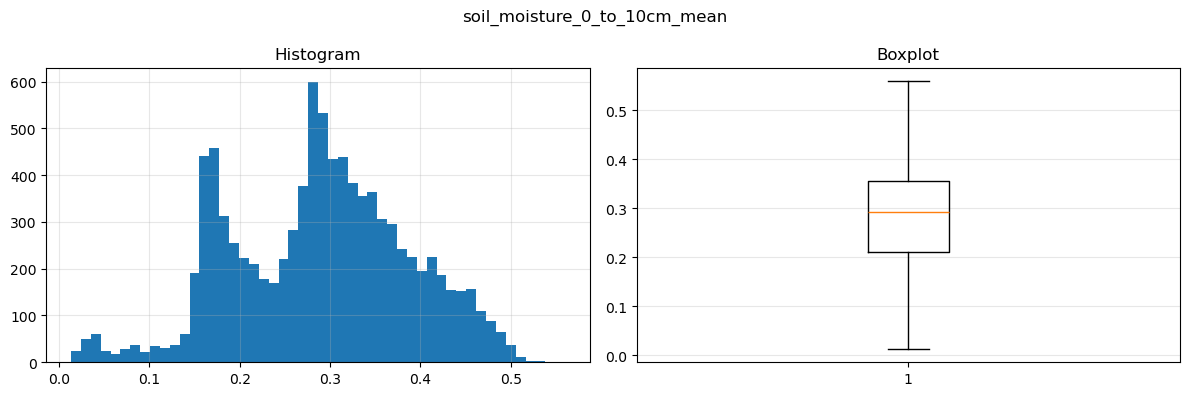

count    9308.000
mean        0.289
std         0.098
min         0.013
1%          0.039
5%          0.148
25%         0.212
50%         0.293
75%         0.357
95%         0.451
99%         0.487
max         0.560
Name: soil_moisture_0_to_10cm_mean, dtype: float64


In [101]:
explore_numeric("soil_moisture_0_to_10cm_mean", flood_df, 'flood_df')

 --- flood_df ---



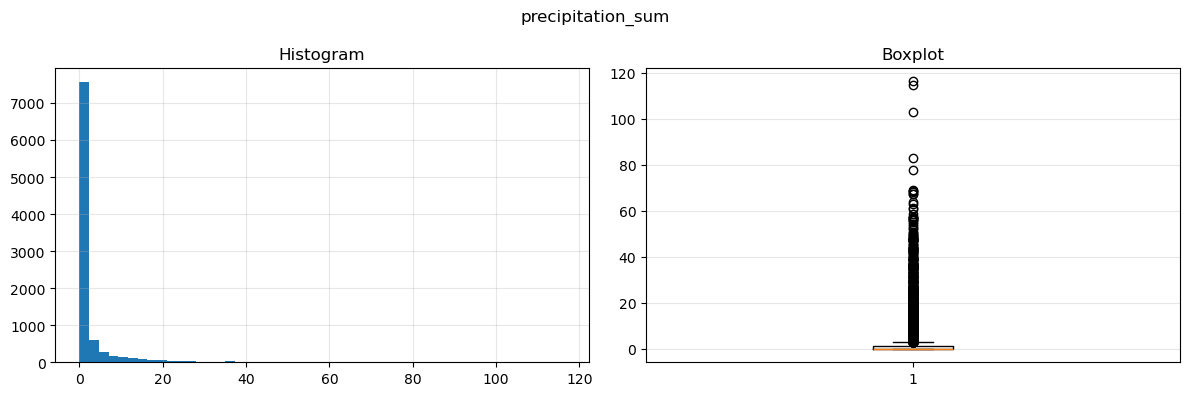

count    9340.000
mean        2.384
std         6.945
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         1.164
95%        14.000
99%        35.967
max       116.481
Name: precipitation_sum, dtype: float64


In [102]:
explore_numeric("precipitation_sum", flood_df, 'flood_df')

In [17]:
def clean_data(df):
    df.drop('snowfall_sum', axis=1, inplace=True)
    df.drop('BEGIN_DAY', axis=1, inplace=True)

    df.dropna(subset=['soil_moisture_0_to_10cm_mean'], inplace=True)

    df = df.sort_values('precipitation_sum')
    df['rain_sum'] = df['rain_sum'].interpolate(method='nearest')
    df = df.sort_index()

    return df

In [18]:
flood_df = clean_data(flood_df)
non_flood_df = clean_data(non_flood_df)
county_test_df = clean_data(county_test_df)

In [20]:
primary_rainy_months = [3, 4, 5]
secondary_rainy_months = [9, 10]

flood_df['is_primary_rain_season'] = flood_df['MONTH'].isin(primary_rainy_months)
flood_df['is_secondary_rain_season'] = flood_df['MONTH'].isin(secondary_rainy_months)

non_flood_df['is_primary_rain_season'] = non_flood_df['MONTH'].isin(primary_rainy_months)
non_flood_df['is_secondary_rain_season'] = non_flood_df['MONTH'].isin(secondary_rainy_months)

county_test_df['is_primary_rain_season'] = county_test_df['MONTH'].isin(primary_rainy_months)
county_test_df['is_secondary_rain_season'] = county_test_df['MONTH'].isin(secondary_rainy_months)

In [21]:
flood_df.head()

,YEAR,MONTH,BEGIN_TIME,BEGIN_LAT,BEGIN_LON,STATE,EVENT_TYPE,FLOOD_CAUSE,EVENT_NARRATIVE,temperature_2m_mean,wind_speed_10m_mean,cloud_cover_mean,relative_humidity_2m_mean,dew_point_2m_mean,precipitation_sum,rain_sum,pressure_msl_mean,soil_moisture_0_to_10cm_mean,elevation,is_primary_rain_season,is_secondary_rain_season
0,2001,3,140,32.53333,-96.66667,TEXAS,Flash Flood,,Roads were closed near Sanger due to high water.,18.331040,21.042433,0.000000,39.388832,4.528868,0.0,0.0,1001.21810,0.432614,146.0,True,False
1,2001,5,15,33.73333,-102.78333,TEXAS,Flash Flood,,I-27 was flooded and subsequently closed due t...,25.134928,22.688942,3.063162,45.882435,12.775488,0.0,0.0,1007.63300,0.110644,1150.0,True,False
2,2001,5,125,31.46667,-97.71667,TEXAS,Flash Flood,,Water was over Northwest Highway at Hillcrest ...,24.716516,13.942765,44.521587,68.509900,18.607435,0.0,0.0,1016.45370,0.302950,265.0,True,False
3,2001,5,128,33.08333,-97.13333,TEXAS,Flash Flood,,Water was over Highway 75 at Parkview.,25.635132,12.174953,53.005688,65.300450,18.778494,0.0,0.0,1016.60834,0.192466,190.0,True,False
4,2001,5,1700,33.36667,-97.68333,TEXAS,Flash Flood,,Flooding resulted in high water rescues and ma...,26.020544,9.831195,54.140934,63.182790,18.967064,0.0,0.0,1016.29364,0.186347,280.0,True,False


/opt/anaconda3/envs/geoai_env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


   BEGIN_LAT  BEGIN_LON Flood_Zone  Is_In_Floodplain
0   32.53333  -96.66667          X             False
1   33.73333 -102.78333        NaN             False
2   31.46667  -97.71667          X             False
3   33.08333  -97.13333         AE              True
4   33.36667  -97.68333          X             False
   BEGIN_LAT  BEGIN_LON Flood_Zone  Is_In_Floodplain
0   32.53333  -96.66667          X             False
1   33.73333 -102.78333        NaN             False
2   31.46667  -97.71667          X             False
3   33.08333  -97.13333         AE              True
4   33.36667  -97.68333          X             False


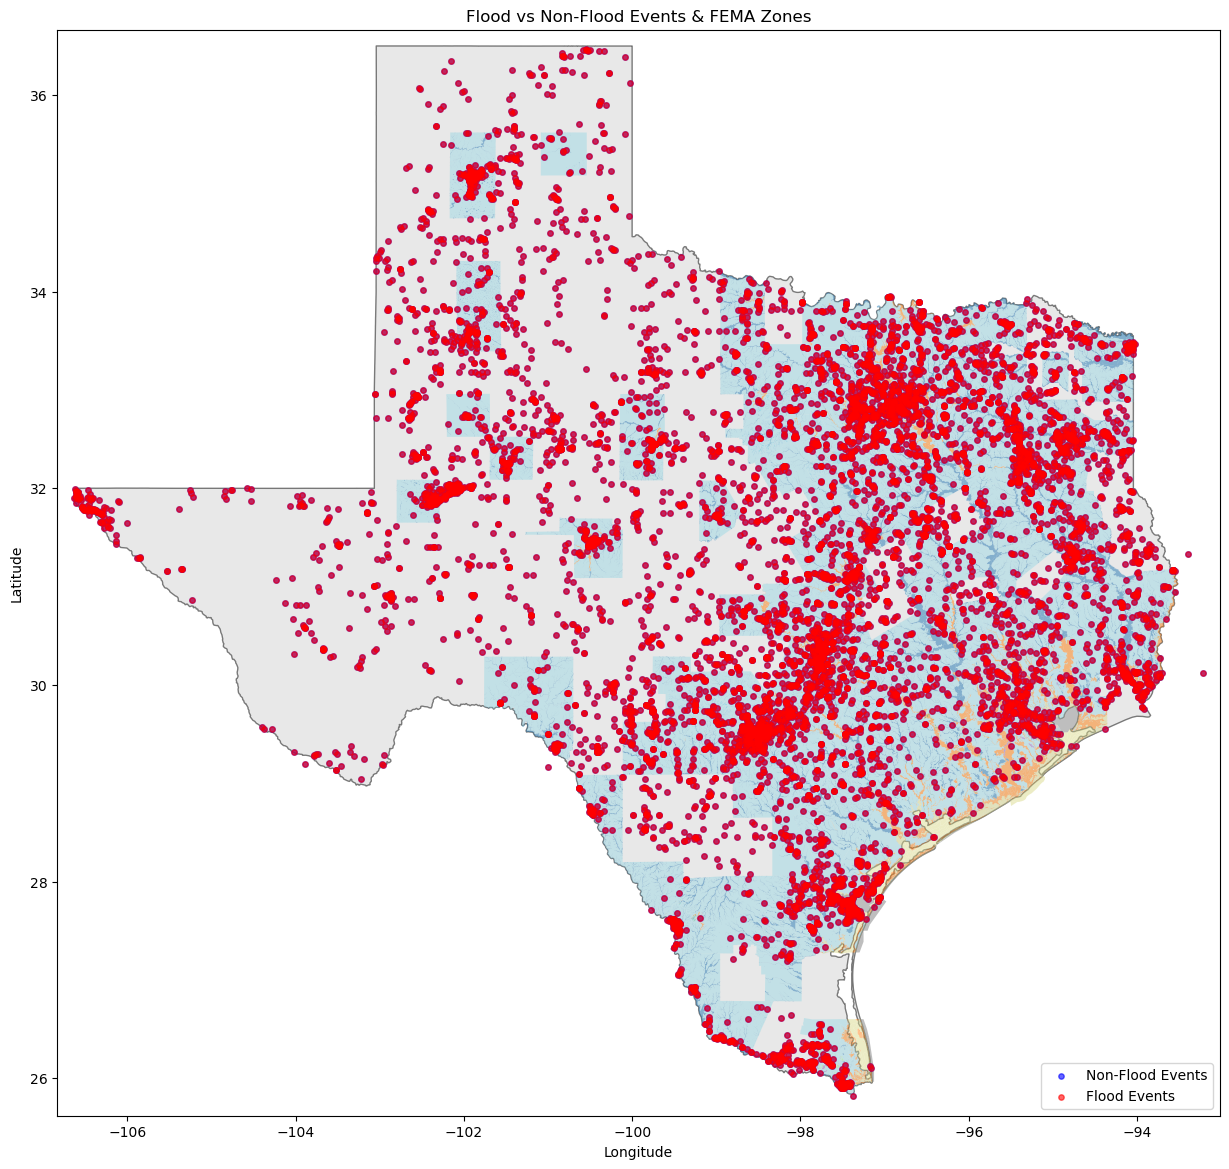

In [23]:
import geopandas as gpd
from shapely.geometry import Point

all_lats = pd.concat([flood_df['BEGIN_LAT'], non_flood_df['BEGIN_LAT'], county_test_df['BEGIN_LAT']])
all_lons = pd.concat([flood_df['BEGIN_LON'], non_flood_df['BEGIN_LON'], county_test_df['BEGIN_LON']])

minx, miny, maxx, maxy = all_lons.min(), all_lats.min(), all_lons.max(), all_lats.max()
bbox_polygon = gpd.GeoSeries([Point(minx, miny), Point(maxx, maxy)], crs="EPSG:4326").envelope
bbox_reprojected = tuple(bbox_polygon.to_crs("EPSG:4269").total_bounds)

gdb_path = "./data/NFHL_48_20251201.gdb" 
layer_name = "S_Fld_Haz_Ar"

try:
    gdf_flood = gpd.read_file(gdb_path, layer=layer_name, bbox=bbox_reprojected)
except Exception as e:
    print(f"bbox read failed, trying full load. Error: {e}")
    gdf_flood = gpd.read_file(gdb_path, layer=layer_name)

gdf_flood = gdf_flood.to_crs("EPSG:4326")

def enrich_with_flood_zone_data(input_df, flood_zones_gdf):
    
    geometry = [Point(xy) for xy in zip(input_df['BEGIN_LON'], input_df['BEGIN_LAT'])]
    gdf_temp = gpd.GeoDataFrame(input_df, geometry=geometry, crs="EPSG:4326")

    joined = gpd.sjoin(gdf_temp, flood_zones_gdf, how="left", predicate="within")

    joined = joined[~joined.index.duplicated(keep='first')]

    input_df['Flood_Zone'] = joined['FLD_ZONE']
    
    high_risk_codes = ['A', 'AE', 'AH', 'AO', 'AR', 'A99', 'V', 'VE']
    input_df['Is_In_Floodplain'] = input_df['Flood_Zone'].isin(high_risk_codes)

    return input_df

flood_df = enrich_with_flood_zone_data(flood_df, gdf_flood)
non_flood_df = enrich_with_flood_zone_data(non_flood_df, gdf_flood)
county_test_df = enrich_with_flood_zone_data(county_test_df, gdf_flood)

print(flood_df[['BEGIN_LAT', 'BEGIN_LON', 'Flood_Zone', 'Is_In_Floodplain']].head())
print(non_flood_df[['BEGIN_LAT', 'BEGIN_LON', 'Flood_Zone', 'Is_In_Floodplain']].head())

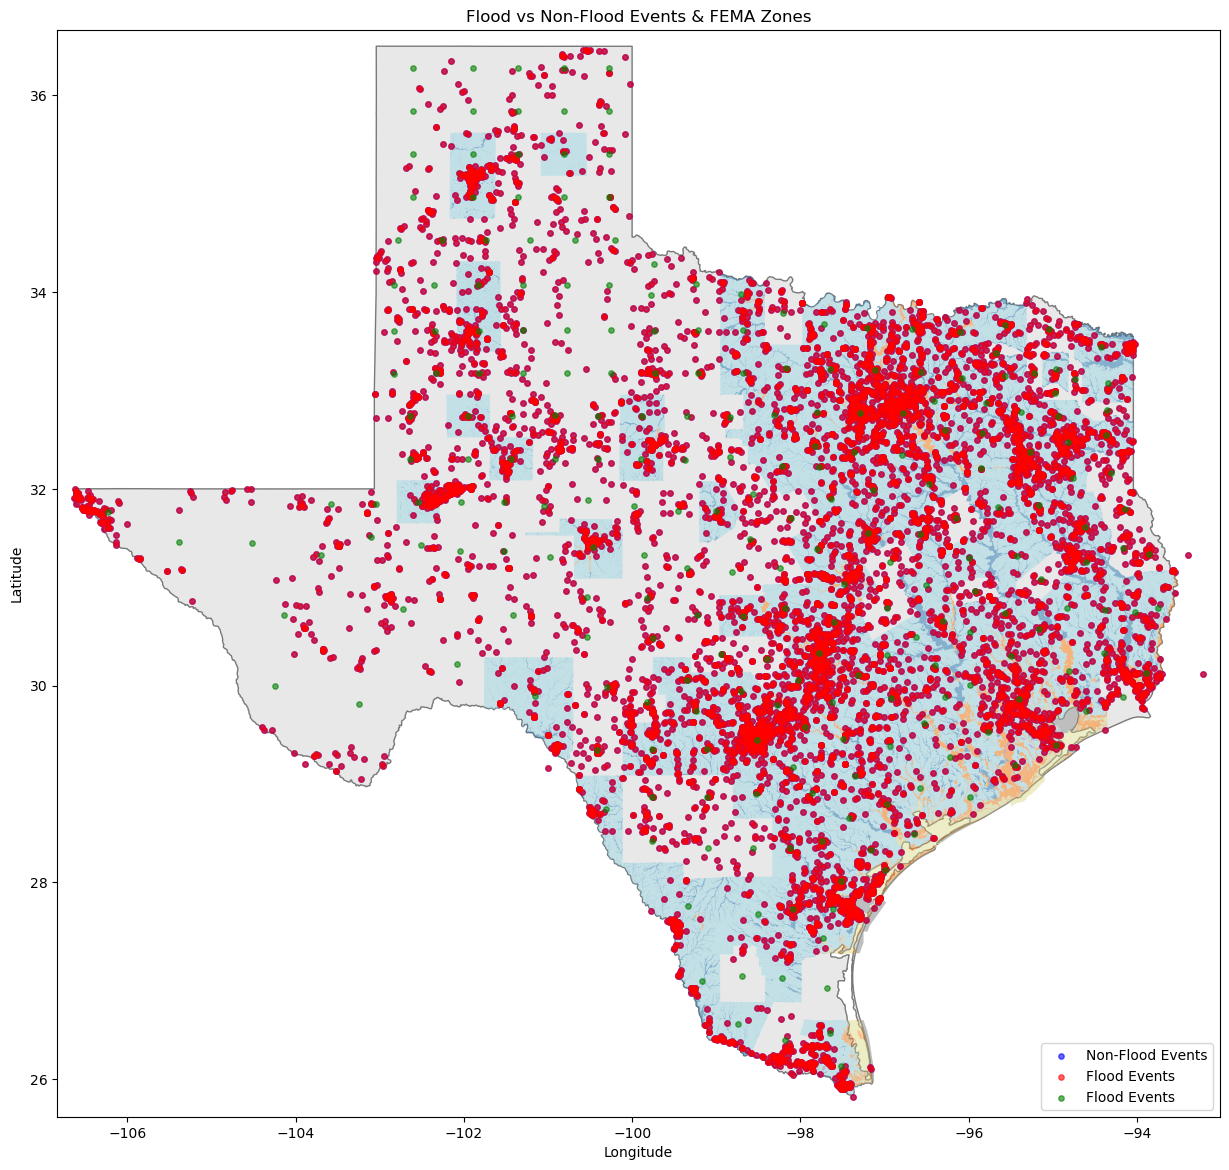

In [28]:
usa_url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json"
usa_gdf = gpd.read_file(usa_url)
texas_map = usa_gdf[usa_gdf['NAME'] == 'Texas']

gdf_flood_points = gpd.GeoDataFrame(
    flood_df, geometry=[Point(xy) for xy in zip(flood_df['BEGIN_LON'], flood_df['BEGIN_LAT'])], crs="EPSG:4326"
)
gdf_non_flood_points = gpd.GeoDataFrame(
    non_flood_df, geometry=[Point(xy) for xy in zip(non_flood_df['BEGIN_LON'], non_flood_df['BEGIN_LAT'])], crs="EPSG:4326"
)
gdf_county_centroids = gpd.GeoDataFrame(
    county_test_df, geometry=[Point(xy) for xy in zip(county_test_df['BEGIN_LON'], county_test_df['BEGIN_LAT'])], crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(15, 15))

texas_map.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

if not gdf_flood.empty:
    gdf_flood.plot(ax=ax, 
                   column='FLD_ZONE', 
                   legend=True,
                   legend_kwds={'title': "Flood Zones", 'loc': 'upper right'},
                   alpha=0.5, 
                   cmap='tab20', 
                   edgecolor='none')

gdf_non_flood_points.plot(ax=ax, color='blue', markersize=15, label='Non-Flood Events', alpha=0.6)
gdf_flood_points.plot(ax=ax, color='red', markersize=15, label='Flood Events', alpha=0.6)
gdf_county_centroids.plot(ax=ax, color='green', markersize=15, label='Flood Events', alpha=0.6)

buffer = 0.2
ax.set_xlim([minx - buffer, maxx + buffer])
ax.set_ylim([miny - buffer, maxy + buffer])

plt.title("Flood vs Non-Flood Events & FEMA Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right')

plt.show()

In [24]:
flood_df = pd.get_dummies(flood_df, columns=['Flood_Zone', 'Is_In_Floodplain'])
non_flood_df = pd.get_dummies(non_flood_df, columns=['Flood_Zone', 'Is_In_Floodplain'])
county_test_df = pd.get_dummies(county_test_df, columns=['Flood_Zone', 'Is_In_Floodplain'])

In [27]:
flood_df.to_csv("./data/cleaned_flood_data.csv", index=False)
non_flood_df.to_csv("./data/cleaned_non_flood_data.csv", index=False)
county_test_df.to_csv("./data/cleaned_county_test_data.csv", index=False)